In [2]:
import os 

datapath = 'universe_8' 
GalaxyNames = []
for clusterFile in os.listdir(datapath + '/Star Clusters'):
    GalaxyNames.append(clusterFile[:-4]) 
    

In [3]:
import pandas as pd
import numpy as np
from astropy.timeseries import LombScargle

freqs = np.linspace(1/120, 0.45, 1000)
distance_data = pd.DataFrame({'Name': GalaxyNames})

PL_dists = np.zeros(len(GalaxyNames))
PL_unc = np.zeros(len(GalaxyNames))
for num, name in enumerate(GalaxyNames): 
    #print(name)
    #cols = pd.read_csv(datapath + f'/Star Clusters/{name}.csv', nrows=1).columns
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.csv', sep = ' ')
    #print(galaxdata.columns)
    variables = galaxdata["Variable?"]
    variableindexes = [i for i, x in enumerate(variables) if x == 1]
    variablenames = galaxdata['Name'][variableindexes].to_numpy()
    periods = np.zeros(len(variablenames)) 
    for i, star in enumerate(variablenames):
        photometryData = pd.read_csv(datapath + f"/Variable_Star_Data/{star}.csv")
        
        time, flux = photometryData['Time'], photometryData['NormalisedFlux'] # just extract the columns as variables
        LS = LombScargle(time, flux) # initialize a Lomb-Scargle fitting
        power = LS.power(freqs) # calculate LS power 
        bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
        pred = LS.model(time, bestfreq) # make a sine wave prediction at the best frequency
        periods[i] = 1 / bestfreq # add each period to the list
        
    intr_lumin = np.zeros(len(periods)) # initialise
    lumin_err = np.zeros(len(periods))
    for i, period in enumerate(periods): 
        if 20 <= period <= 35:
            intr_lumin[i] = 10**(-0.086 * period + 28.25)
            AB = 0.087 * period * np.sqrt((0.002 / 0.087)**2 + (0.1 / period)**2)
            AB_C = np.sqrt(AB**2 + 0.04**2)
            lumin_err[i] = intr_lumin[i] * (np.log(10) * AB_C)
        if 35 <= period <= 55:
            intr_lumin[i] = 10**(-0.087 * period + 33.72)
            AB = 0.087 * period * np.sqrt((0.002 / 0.087)**2 + (0.1 / period)**2)
            AB_C = np.sqrt(AB**2 + 0.08**2)
            lumin_err[i] = intr_lumin[i] * (np.log(10) * AB_C)
        elif 80 <= period <= 110:
            intr_lumin[i] = 10**(-0.087 * period + 34.35)
            AB = 0.087 * period * np.sqrt((0.001 / 0.087)**2 + (0.1 / period)**2)
            AB_C = np.sqrt(AB**2 + 0.06**2)
            lumin_err[i] = intr_lumin[i] * (np.log(10) * AB_C)
            
    # now to finally compare intr_lumin against the fluxes to obtain distances
    greenFluxes = galaxdata['GreenF'][variableindexes].to_numpy()
    distances = []
    distance_unc = []
    
    if len(intr_lumin) > 10: # we only want to look at galaxies with reasonably high sample size of variables
        for i, lumin in enumerate(intr_lumin):
            if lumin > 0: # this is to avoid noisy data
                distance_m = np.sqrt(lumin / (4 * np.pi * greenFluxes[i]))
                distance_pc = distance_m / (3.086 * 10**16)
                distances.append(distance_pc)
                
                lumin_unc = distance_m**2 * np.sqrt((lumin_err[i] / lumin)**2 + (0.01)**2)
                distance_pc_unc = abs(distance_m * 0.5 * lumin_unc / distance_m**2) / (3.086*10**16)
                distance_unc.append(distance_pc_unc)
        # now we need to remove any (inevitable) outliers from the data
        q1, q3 = np.percentile(distances, [25, 75])
        IQR = q3 - q1
        # the below checks if the data point is within 2.7 standard deviations of the mean
        upper = q3 + 1.5*IQR
        lower = q1 - 1.5*IQR
        # now we only care about data within 2.7 STDs 
        distances = [dist for dist in distances if lower <= dist <= upper]
        distance_unc = [distance_unc[i] for i, x in enumerate(distances) if lower <= x <= upper]
    PL_dists[num] = np.mean(distances)
    PL_unc[num] = np.mean(distance_unc)

c:\Users\neha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\neha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\neha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\neha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\neha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\neha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\neha

In [4]:
distance_data['PL_distance'] = PL_dists
distance_data['PL_unc'] = PL_unc

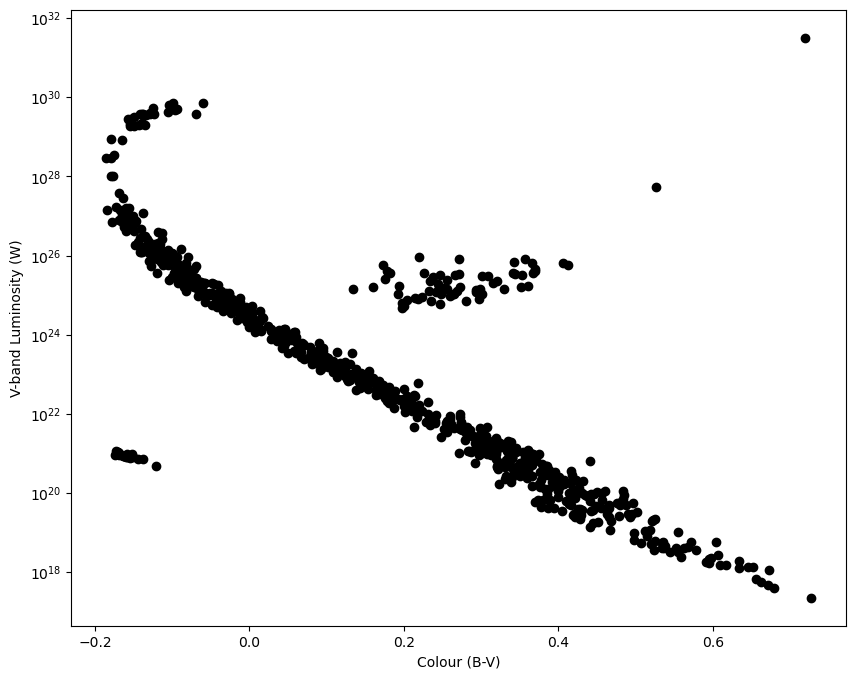

In [12]:
import matplotlib.pyplot as plt

allstardata = pd.read_csv(datapath + '/combined_stars.csv')   

parallax = allstardata['Parallax']    # get the parallax of the stars


localindex = [i for i, x in enumerate(parallax) if x > 0.007]
localVflux = np.array(allstardata["GreenF"])[localindex]
localBflux = np.array(allstardata["BlueF"])[localindex]
BV = np.log10(localVflux / localBflux) # B-V colour index 

localVlumin = localVflux * 4 * np.pi * (1 / np.array(allstardata["Parallax"][localindex]) * 3.086 * 10**16)**2

fig = plt.figure(figsize=(10, 8))  
ax = fig.add_subplot(1, 1, 1)   
ax.scatter(BV, localVlumin, c='k')
ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');

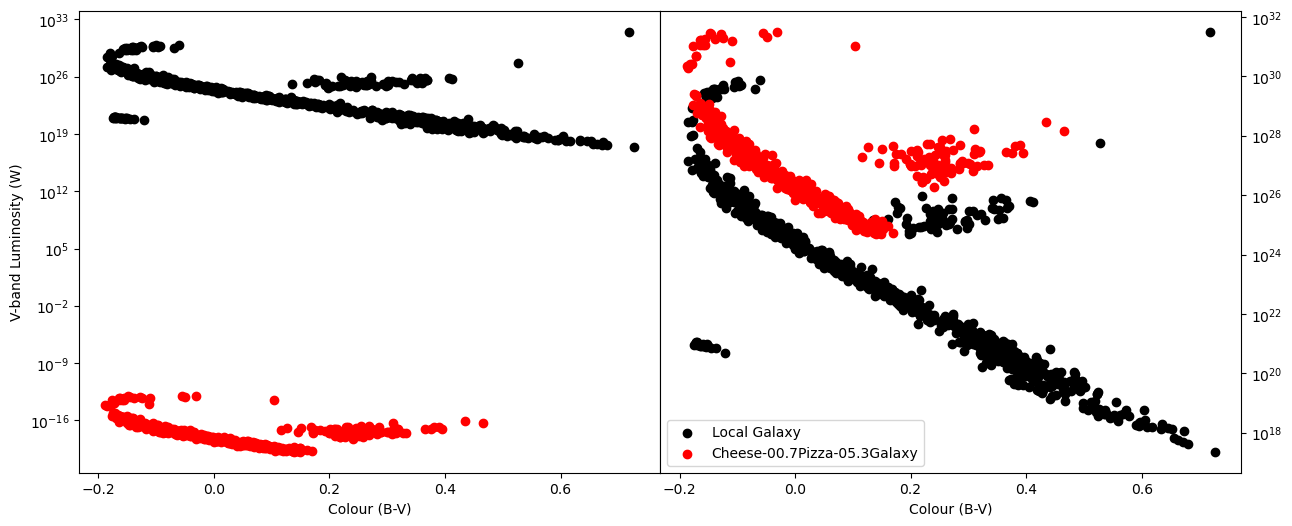

In [11]:
MS_dist = np.zeros(len(GalaxyNames))
MS_unc = np.zeros(len(GalaxyNames))
X = np.zeros(len(GalaxyNames))
Y = np.zeros(len(GalaxyNames))
for num, name in enumerate(GalaxyNames):
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.csv', delimiter=' ')
    galaxVflux = np.array(galaxdata["GreenF"])
    galaxBflux = np.array(galaxdata["BlueF"])

    galaxBV = np.log10(galaxVflux / galaxBflux) # B-V colour index 
    
    offset = max(np.log10(localVlumin)) - max(np.log10(galaxVflux))
    
    dist_m = np.sqrt(10**offset / (4 * np.pi))
    dist_pc = dist_m / (3.086 * 10**16)
    
    dist_pc_unc = (dist_m**2 * np.log(10) * np.sqrt(2) * 0.01 / (4 * np.pi)) * 0.5 * dist_m / (dist_m**2 * (3.086*10**16))
    
    MS_dist[num] = dist_pc
    MS_unc[num] = dist_pc_unc

    
    
    if num == 5:
        fig, [ax, ax2] = plt.subplots(1, 2, figsize=(15, 6))
        fig.subplots_adjust(wspace=0)
        
        ax.scatter(galaxBV, galaxVflux, c='r')
        ax.scatter(BV, localVlumin, c='k')
        ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');
        
        ax2.scatter(BV, localVlumin,  c='k', label="Local Galaxy")
        ax2.scatter(galaxBV, galaxVflux * 10**offset, c='r', label=f"{GalaxyNames[num]}")
        ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")
        ax2.set_yscale('log'); ax2.set_xlabel('Colour (B-V)')
        ax2.legend(loc='lower left')
        
    

In [40]:
distance_data['MS_distance'] = MS_dist
distance_data['MS_unc'] = MS_unc
distance_data.to_csv(datapath + '/Galaxy_Distances.csv', index=None, sep=' ')

distance_data

,Name,PL_distance,PL_unc,MS_distance,MS_unc
0,Cheese-0.12734780487804878Pizza-12.30588292682...,18812.991250,1457.117253,96593.917273,125.152810
1,Cheese-0.5590729881823298Pizza-15.085296567248...,17547.473092,1527.809894,104671.966989,135.619211
2,Cheese-0.656434251968504Pizza-5.26184074803149...,26333.855891,1934.280724,166286.818802,215.451068
3,Cheese-00.1Pizza-12.3Galaxy,18812.991250,1457.117253,96593.917273,125.152810
4,Cheese-00.6Pizza-15.1Galaxy,17547.473092,1527.809894,104671.966989,135.619211
...,...,...,...,...,...
244,X038.5-Y029.5-N583,28566.185085,2331.714211,161938.157492,209.816685
245,X039.6-Y-10.7-N639,3671.813606,304.080148,25551.441922,33.105964
246,X041.1-Y032.0-N398,NaN,NaN,186837.345378,242.077550
247,X041.5-Y-04.3-N229,1034.291533,155.439112,5208.301611,6.748185
